# Sounding Rocket Guidance Algorithm

We shall describe a simple guidance algorithm for a re-usable sounding rocket. This algorithm allows the rocket to reach a desired maximum height, and proceed to intercept a specified target point for parachute deployment. This is derived under the assumption of uniform gravitational acceleration (the "flat earth" model), ignoring aerodynamic forces. The algorithm is expressed in the 2D trajectory plane of the rocket, but can be extended to cancel non-planar drift. 

Following derivation of the algorithm, we perform an integration of the rockets equations of motion with continuous guidance equations included, from given initial conditions, to compute its flight path.

## Equations of Motion

The rocket is modeled as a point particle. The first order vector equations of motion are:

$$
\begin{bmatrix}
\dot{\mathbf{x}}\\
\dot{\mathbf{v}}\\
\dot{m}
\end{bmatrix}
=
\begin{bmatrix}
\mathbf{v}\\
\mathbf{F}/m\\
-\mu
\end{bmatrix}
$$

in which $\mathbf{x}$ is the position, $\mathbf{v}$ is the velocity, $m$ is the instantaneous rocket mass, $\mu$ is the mass flow rate of propellant, and $\mathbf{F}$ is the total force acting on the rocket. In the flat-earth model, ignoring aerodynamic (and other smaller) forces, the total force acting on the rocket is given by:

$$
\mathbf{F} = \mathbf{F_T} + \mathbf{F_G} + (\mathbf{F}_{\mathrm{aerodynamic}} + \mathbf{F}_{\mathrm{magnetic}} + \ldots)
$$

where $\mathbf{F_T}$ is the thrust of the rocket (which will be determined later once we have a guidance algorithm), and $\mathbf{F_G}$ is the force due to gravity. The gravitational force acts downward and its magnitude is:

$$
|\mathbf{F_G}| = gm
$$

where $g$ is the acceleration due to gravity ($g \approxeq 9.81m/s^2$). Assuming a simple rocket motor that cannot be throttled, and that the performance of the engine is approximately constant, the magnitude of the thrust vector is constant until shutoff, and is given by:

$$
|\mathbf{F_T}| = F_T = gI_s\mu
$$

where $I_s$ is the specific impulse of the engine + propellant combination. We can thus expand the equations of motion into scalar components in the trajectory plane as follows:

$$
\begin{bmatrix}
\dot{x} \\
\dot{z} \\
\dot{v_x} \\
\dot{v_z} \\
\dot{m}
\end{bmatrix}
=
\begin{bmatrix}
v_x \\
v_z \\
F_{Tx}/m \\
F_{Tz}/m - g \\
-\mu
\end{bmatrix}
$$

In which $x$ is the downrange (horizontal) coordinate of the trajectory and $z$ is the vertical coordinate.

## Guidance Equations

The desired trajectory for the rocket will be parabolic. It will be specified by 3 values:
  - $x_T$ : the downrange coordinate of the target (for parachute deployment)
  - $y_T$ : the altitude coordinate of the target (for parachute deployment)
  - $h$ : peak altitude

Our general approach to guidance will be to compute the changes that are necessary to move the rocket's current state vector to a state vector which will simultaneously reach the desired peak altitude and intercept the target coordinates.

### Free-Fall Trajectory

Consider any current point of the rocket's flight path, at which it has position coordinates $(x_0, z_0)$. At this point, we first compute the free-fall trajectory ($\mathbf{F}_T = 0$) which would satisfy the guidance objectives described above. For a free-fall trajectory, we have the following equations of motion:

$$
\begin{bmatrix}
\dot{x} \\
\dot{z} \\
\dot{v_x} \\
\dot{v_z} \\
\dot{m}
\end{bmatrix}
=
\begin{bmatrix}
v_x \\
v_z \\
0 \\
-g \\
0
\end{bmatrix}
$$

These can be integrated analytically (exercise for the reader) to produce the expected equations of a free-fall parabolic trajectory:

$$
\begin{split}
x &= v_{cx}t + x_0 \\
z &= -\frac{1}{2}gt^2 + v_{cz}t + z_0
\end{split}
$$

In these equations, time ($t$) is measured from zero at the current time (ie. at $t=0$, $x=x_0$ and $z=z_0$). The new variables arising from constants of integration are:
  - $x_0$: the current x coordinate
  - $z_0$: the current z coordinate
  - $v_{cx}$: the horizontal velocity of the rocket (the velocity which will be required to reach the target)
  - $v_{cz}$: the vertical velocity of the rocket (the velocity which will be required to reach the target)

The velocity $\mathbf{v_c}$ (under targeted guidance) is sometimes called the "correlated velocity" in the guidance literature. We need to compute this velocity in order to determine how to reach this free-fall, target-intercepting trajectory. First consider the peak altitude. At this peak altitude, $v_z=0$, $z=h$ and let $t=t_h$. We can substitute these values into the vertical equation of motion:

$$
h = -\frac{1}{2}gt_h^2 + v_{cz}t_h + z_0
$$

which can be solved as a quadratic equation for $t_h$:

$$
t_h = \frac{v_{cz} \pm \sqrt{v_{cz}^2 - 2g(h-z_0)}}{g}
$$

Substituting this into the vertical velocity equation allows us to derive $v_{cz}$:

$$
\begin{split}
0 &= -gt_h + v_{cz} \\
v_{cz} &= \sqrt{2g(h-z_0)}
\end{split}
$$

Now consider the target intercept. Let $t_{go}$ be the time remaining until we intercept the target. Thus, at $t=t_{go}$, $x=x_T$ and $z=z_T$. Substitute these values into the vertical equation of motion:

$$
z_T = -\frac{1}{2}gt_{go}^2 + v_{cz}t_{go} + z_0
$$

which can again be solved as a quadtratic equation in $t_{go}$:

$$
t_{go} = \frac{v_{cz} \pm \sqrt{v_{cz}^2 - 2g(z_T - z)}}{g}
$$

And finally, given this expression for $t_{go}$, we can compute the required horizontal velocity from the horizontal equation of motion as:

$$
v_{cx} = \frac{x_T - x_0}{t_{go}}
$$

(Note: In some guidance literature, $t_{go}$ refers to the time remaining in *powered* flight. I am using it to refer to the total time remaining here, because that is more convenient.)

### Guidance Law

Above we have computed the correlated velocity; the velocity that the rocket *would require* to intercept the target from our current position and reach the desired peak altitude simultaneously. Of course, the rocket does not necessarily possess that velocity, and in general it doesn't otherwise no thrust would be required. In order to drive the rocket toward the required trajectory, we shall use one of the simplest guidance laws: thrust in the direction of velocity-to-be-gained! The reasoning here is that, by moving the rocket toward the desired trajectory, we might reach conditions, at some later time, when the rocket's true velocity instantaneously matches the required velocity. (This indeed works; as will be demonstrated in the numerical simulations below.)

First, we introduce the velocity-to-be-gained, $\mathbf{v_g}$, which is given by:

$$
\mathbf{v_g} = \mathbf{v_c} - \mathbf{v}
$$

(where $\mathbf{v}$ is the current velocity). We thrust in this direction, which means that our thrust vector is given by:

$$
\mathbf{F_T} = gI_s\mu \hat{\mathbf{v_g}}
$$

where $\hat{\mathbf{v_g}}$ is the normalized velocity to be gained (a unit vector in that direction).

### Thrust Termination Conditions

For the rocket's flight to satisfactorily follow the desired trajectory, we shall cut off its engine when $\mathbf{v_g} = 0$. However, we should also consider the possibility that the rocket runs out of fuel before that can be satisfied (see below).

In [1]:
# When was this notebook executed?
from datetime import datetime
print(f"Notebook executed: {datetime.now()}")

Notebook executed: 2020-12-14 04:10:44.390246


## Problem Parameters

We will begin by specifying some parameters for the problem. These include both parameters of the rocket and the target intercept location.

In [2]:
# Rocket Parameters
g = 9.81                # m/s^2 - acceleration due to Earth gravity
I_s = 250.0             # s     - approximate specific impulse of a low-end LOx/SP4 rocket
mu = 0.6                # kg/s  - mass flow rate of propellant
m_dry = 20.0            # kg    - dry mass of the rocket (after all the propellant has been burnt)
m_wet = 100.0           # kg    - wet (launch) mass of the rocket

# Target Parameters
h = 250.0 * 1000.0     # m - maximum altitude
x_T = 100.0 * 1000.0   # m - down-range target (point for parachute deployment)
z_T = 750.0            # m - vertical target (point for parachute deployment)

## Stages of Flight

We will split the rocket's flight into two stages:
  1. Powered flight, terminated when the velocity-to-go reaches zero OR the rocket burns all its fuel.
  1. Free-fall flight, terminated when the horizontal position passes the target.
  
These will be simulated by expressing the guidance equations as continuous equations incorporated into the first-order equations of motion of the rocket. Then the trajectory will be solved by integrating an initial-value problem.

In [3]:
# Equations of motion for powered flight, with guidance equations included.

from math import sqrt

def compute_vg(t, state):
    """Compute velocity-to-be-gained for powered flight."""

    # Extract individual state variables from the state vector (for clarity).
    x = state[0]   # down-range coordinate
    z = state[1]   # vertical coordinate
    vx = state[2]  # down-range velocity
    vz = state[3]  # vertical velocity
    # m = state[4]   # instantaneous mass

    # Compute correlated velocity
    # This is the velocity that the rocket would need to have at the
    # current instant in order to satisfy the guidance objectives.
    v_cz = sqrt(2*g*(h - z))
    tgo = (v_cz + sqrt(v_cz*v_cz - 2*g*(z_T - z))) / g
    v_cx = (x_T - x) / tgo
        
    # Return velocity-to-be-gained
    v_gx = v_cx - vx
    v_gz = v_cz - vz
    return [v_gx, v_gz]
    
    
def eom_powered(t, state):
    """Equation of motion for powered flight, with guidance included."""
    
    # Extract individual state variables from the state vector (for clarity).
    x = state[0]   # down-range coordinate
    z = state[1]   # vertical coordinate
    vx = state[2]  # down-range velocity
    vz = state[3]  # vertical velocity
    m = state[4]   # instantaneous mass
    
    # Compute velocity-to-be-gained
    vg = compute_vg(t, state)
    v_gx = vg[0]
    v_gz = vg[1]
    
    # Normalize velocity-to-be-gained
    vg = sqrt(v_gx*v_gx + v_gz*v_gz)
    vhat_gx = v_gx / vg
    vhat_gz = v_gz / vg
    
    # Determine thrust force
    F_Tx = g * I_s * mu * vhat_gx
    F_Tz = g * I_s * mu * vhat_gz
    
    # Compute and return state gradient
    xdot = vx
    zdot = vz
    vdot_x = F_Tx / m
    vdot_z = F_Tz / m - g
    mdot = -mu
    return [ xdot, zdot, vdot_x, vdot_z, mdot ]


def eom_powered_terminate_propellant_exhausted(t, state):
    """Event function to terminate powered flight when propellant is exhausted."""
    m = state[4]  # instantaneous mass
    return (m - m_dry)  # terminate when the mass is the dry mass


def eom_powered_terminate_vg(t, state):
    """Event function to terminate powered flight when velocity-to-be-gained is zero."""
    vg = compute_vg(t, state)
    v_gx = vg[0]  # we just use the horizontal component for simplicity
    return v_gx


eom_powered_terminate_propellant_exhausted.terminal = True
eom_powered_terminate_vg.terminal = True

In [4]:
# Integrate the equations of motion for powered flight

from scipy.integrate import solve_ivp

# List of events that will terminate the integrator.
powered_events = [
    eom_powered_terminate_vg,
    eom_powered_terminate_propellant_exhausted
]
# Invoke the initial-value-problem integrator.
powered_result = solve_ivp(
    eom_powered,
    (0, 1000.0),
    [0.0, 0.0, 0.0, 0.0, m_wet],
    method='RK45',
    dense_output=True,
    events=powered_events,
    max_step=1.0,
    rtol=1e-3,
    atol=1e-6
)
# Extract state vectors
state_powered = powered_result.y
t_powered = powered_result.t

In [5]:
# Equations of motion for free-fall flight

def eom_free(t, state):
    """Equation of motion for free-fall flight."""
    
    # Extract individual state variables from the state vector (for clarity).
    x = state[0]   # down-range coordinate
    z = state[1]   # vertical coordinate
    vx = state[2]  # down-range velocity
    vz = state[3]  # vertical velocity
    m = state[4]   # instantaneous mass
    
    # Compute and return state gradient
    xdot = vx
    zdot = vz
    vdot_x = 0
    vdot_z = -g
    mdot = 0.0
    return [ xdot, zdot, vdot_x, vdot_z, mdot ]


def eom_free_terminate_intercept(t, state):
    """Event function to terminate powered flight when propellant is exhausted."""

    # Extract individual state variables from the state vector (for clarity).
    x = state[0]   # down-range coordinate
    z = state[1]   # vertical coordinate
    vx = state[2]  # down-range velocity
    vz = state[3]  # vertical velocity
    m = state[4]   # instantaneous mass

    # Compute horizontal distance to target
    r_Tx = x_T - x
    return r_Tx


eom_free_terminate_intercept.terminal = True

In [6]:
# Integrate the equations of motion for free-fall flight

# List of events that will terminate the integrator.
free_fall_events = [
    eom_free_terminate_intercept
]
# Determine initial state (final state of the powered flight)
state_free_init = [
    state_powered[0][-1],
    state_powered[1][-1],
    state_powered[2][-1],
    state_powered[3][-1],
    state_powered[4][-1]
]
# Invoke the initial-value-problem integrator.
free_fall_result = solve_ivp(
    eom_free,
    (t_powered[-1], 10.0 * 60.0),
    state_free_init,
    method='RK45',
    dense_output=True,
    events=free_fall_events,
    max_step=1.0,
    rtol=1e-3,
    atol=1e-6
)
# Extract state vectors
state_free_fall = free_fall_result.y
t_free_fall = free_fall_result.t

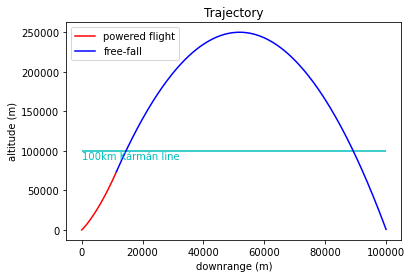

In [7]:
# Plot the trajectory

import matplotlib.pyplot as plt

x_powered = state_powered[0]
z_powered = state_powered[1]
x_free = state_free_fall[0]
z_free = state_free_fall[1]

powered_curve, = plt.plot(x_powered, z_powered, 'r', label='powered flight')
free_curve, = plt.plot(x_free, z_free, 'b', label='free-fall')
plt.hlines(100000.0, 0.0, x_T, 'c', label='100km Kármán line')
plt.text(0, 100000.0, "100km Kármán line", color='c', verticalalignment='top')
plt.legend(handles=[powered_curve, free_curve])
plt.title("Trajectory")
plt.xlabel('downrange (m)')
plt.ylabel('altitude (m)')
plt.show()

Final vehicle mass   = 29.129174842084048 kg
Propellant remaining = 9.129174842084048 kg


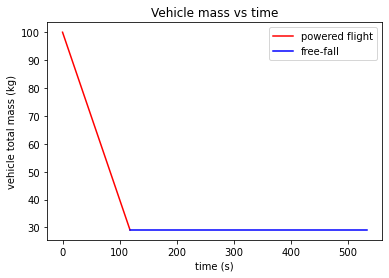

In [16]:
# Plot the rocket mass vs time

mass_powered = state_powered[4]
mass_free = state_free_fall[4]

final_mass = mass_powered[-1]
propellant_remaining = final_mass - m_dry
print(f"Final vehicle mass   = {final_mass} kg")
print(f"Propellant remaining = {propellant_remaining} kg")

powered_curve, = plt.plot(t_powered, mass_powered, 'r', label='powered flight')
free_curve, = plt.plot(t_free_fall, mass_free, 'b', label='free-fall')
plt.legend(handles=[powered_curve, free_curve])
plt.title("Vehicle mass vs time")
plt.xlabel('time (s)')
plt.ylabel('vehicle total mass (kg)')
plt.show()

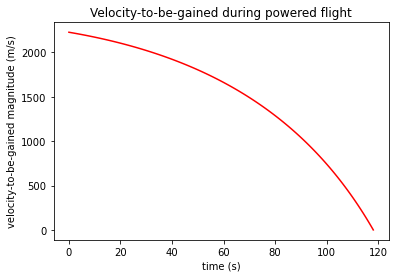

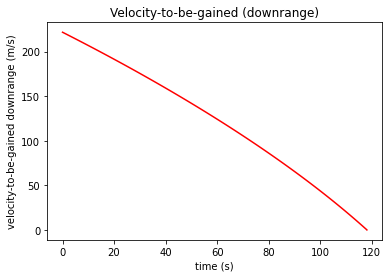

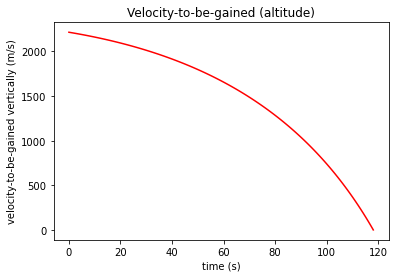

In [21]:
# Plot the magnitude of the velocity-to-be-gained during powered flight

state_powered_transpose = list(map(list, zip(*state_powered)))
vg_vvec = list(map(lambda state: compute_vg(0.0, state), state_powered_transpose))
vg = list(map(lambda v: sqrt(v[0]*v[0] + v[1]*v[1]), vg_vvec))
vg_x = list(map(lambda v: v[0], vg_vvec))
vg_z = list(map(lambda v: v[1], vg_vvec))

plt.plot(t_powered, vg, 'r')
plt.title("Velocity-to-be-gained during powered flight")
plt.xlabel('time (s)')
plt.ylabel('velocity-to-be-gained magnitude (m/s)')
plt.show()

plt.plot(t_powered, vg_x, 'r')
plt.title("Velocity-to-be-gained (downrange)")
plt.xlabel('time (s)')
plt.ylabel('velocity-to-be-gained downrange (m/s)')
plt.show()

plt.plot(t_powered, vg_z, 'r')
plt.title("Velocity-to-be-gained (altitude)")
plt.xlabel('time (s)')
plt.ylabel('velocity-to-be-gained vertically (m/s)')
plt.show()

## Some shortcomings

- Aerodynamic forces were not included in the simulation or guidance.
- Changes in rocket engine thrust with altitude were not modeled.
- Variation in gravitational force with altitude was not modeled.
- Perfect navigation and instantaneous thrust vectoring were assumed.
- No optimal control objectives were considered.

## Bibliography (useful or interesting sources)

- Sarture, C.W. (1960) Guidance schemes for rocket vehicles. from A Short Course on Inertial Guidance, UCLA. STL/TN-60-0000-GR186, AD 607714. https://apps.dtic.mil/dtic/tr/fulltext/u2/607714.pdf - These notes by Sarture contain a similar guidance algorithm to the one presented here, as part of a wider presentation on the topic.

- Philliou, P.J. (1964) Optimal Guidance Laws. Space Guidance Analysis Memo #38-64, MIT Instrumentation Laboratory, Apollo Project. https://www.ibiblio.org/apollo/Documents/SGA_Memo38_640923.pdf - This technical memo describes a more sophisticated set of guidance laws derived from optimal control.

- Hall, L and Ljunge, L (1999) The DS19, A New High Performance Guidance System. Proceedings of the 14th ESA Symposium. http://articles.adsabs.harvard.edu/cgi-bin/nph-iarticle_query?db_key=AST&bibcode=1999ESASP.437..155H - This article describes an aerodynamic guidance system for sounding rockets (AFAICT, more common than the thrust vectoring approach I allude to above).

- Levine, G.M. (ed) (1972) Apollo: Guidance, Navigation and Control, section 5: Guidance Equations, Charles Stark Draper Laboratory, MIT. https://www.ibiblio.org/apollo/Documents/j2-80-R-567-SEC5-REV11_text.pdf - This document describes (but sadly does not derive) the guidance algorithms used during the later Apollo missions.

- https://en.wikipedia.org/wiki/Sounding_rocket - Wikipedia page on sounding rockets (what are they, what do they do, etc.)